In [1]:
!pip install numpy pandas Pillow torch git+https://github.com/openai/CLIP.git pydicom tqdm scikit-learn imageio opencv-python scipy


  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-g4bcopcl
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-g4bcopcl
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.0 MB/s eta 0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369489 sha256=c557b03f0c9f70d664100a1325cc9ed560ac366394f76cad6cf96aad9c152643
  Stored in directory: /tmp/pip-ephem-wheel-cache-js7u9e_w/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip


In [2]:
from scipy.spatial import distance
import numpy as np
import pandas as pd
from PIL import Image
import torch
import clip
import pydicom
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression, LinearRegression
import os
import imageio
import cv2


for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)
print("Path Join Completed")


Path Join Completed


In [3]:
df_meta= pd.read_csv('/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/csv/meta.csv')
df_meta.head()

,SeriesInstanceUID,StudyInstanceUID,Modality,SeriesDescription,BodyPartExamined,SeriesNumber,Collection,Visibility,ImageCount
0,1.3.6.1.4.1.9590.100.1.2.117041576511324414842...,1.3.6.1.4.1.9590.100.1.2.229361142710768138411...,MG,ROI mask images,BREAST,1,CBIS-DDSM,1,2
1,1.3.6.1.4.1.9590.100.1.2.438738396107617880132...,1.3.6.1.4.1.9590.100.1.2.195593486612988388325...,MG,ROI mask images,BREAST,1,CBIS-DDSM,1,2
2,1.3.6.1.4.1.9590.100.1.2.767416741131676463382...,1.3.6.1.4.1.9590.100.1.2.257901172612530623323...,MG,ROI mask images,BREAST,1,CBIS-DDSM,1,2
3,1.3.6.1.4.1.9590.100.1.2.296931352612305599800...,1.3.6.1.4.1.9590.100.1.2.109468616710242115222...,MG,ROI mask images,BREAST,1,CBIS-DDSM,1,2
4,1.3.6.1.4.1.9590.100.1.2.436657670120353100077...,1.3.6.1.4.1.9590.100.1.2.380627129513562450304...,MG,ROI mask images,BREAST,1,CBIS-DDSM,1,2


In [4]:
df_dicom = pd.read_csv('/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/csv/dicom_info.csv')
df_dicom.head()

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pan

,file_path,image_path,AccessionNumber,BitsAllocated,BitsStored,BodyPartExamined,Columns,ContentDate,ContentTime,ConversionType,...,SecondaryCaptureDeviceManufacturerModelName,SeriesDescription,SeriesInstanceUID,SeriesNumber,SmallestImagePixelValue,SpecificCharacterSet,StudyDate,StudyID,StudyInstanceUID,StudyTime
0,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.12930...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.129308...,NaN,16,16,BREAST,351,20160426,131732.685,WSD,...,MATLAB,cropped images,1.3.6.1.4.1.9590.100.1.2.129308726812851964007...,1,23078,ISO_IR 100,20160720.0,DDSM,1.3.6.1.4.1.9590.100.1.2.271867287611061855725...,214951.0
1,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.24838...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.248386...,NaN,16,16,BREAST,3526,20160426,143829.101,WSD,...,MATLAB,full mammogram images,1.3.6.1.4.1.9590.100.1.2.248386742010678582309...,1,0,ISO_IR 100,20160720.0,DDSM,1.3.6.1.4.1.9590.100.1.2.161516517311681906612...,193426.0
2,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.26721...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.267213...,NaN,16,16,BREAST,1546,20160503,111956.298,WSD,...,MATLAB,full mammogram images,1.3.6.1.4.1.9590.100.1.2.267213171011171858918...,1,0,ISO_IR 100,20160807.0,DDSM,1.3.6.1.4.1.9590.100.1.2.291043622711253836701...,161814.0
3,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.38118...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.381187...,NaN,16,16,BREAST,97,20160503,115347.770,WSD,...,MATLAB,cropped images,1.3.6.1.4.1.9590.100.1.2.381187369611524586537...,1,32298,ISO_IR 100,20170829.0,DDSM,1.3.6.1.4.1.9590.100.1.2.335006093711888937440...,180109.0
4,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.38118...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.381187...,NaN,8,8,Left Breast,3104,20160503,115347.770,WSD,...,MATLAB,NaN,1.3.6.1.4.1.9590.100.1.2.381187369611524586537...,1,0,ISO_IR 100,NaN,DDSM,1.3.6.1.4.1.9590.100.1.2.335006093711888937440...,NaN


In [5]:
df_dicom.SeriesDescription.unique()

array(['cropped images', 'full mammogram images', nan, 'ROI mask images'],
      dtype=object)

In [6]:
cropped_images = df_dicom[df_dicom.SeriesDescription=='cropped images'].image_path
cropped_images.head(5)

0     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.129308...
3     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.381187...
6     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.153339...
7     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.178994...
10    CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.411833...
Name: image_path, dtype: object

In [7]:
full_mammo = df_dicom[df_dicom.SeriesDescription=='full mammogram images'].image_path
full_mammo.head()


1     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.248386...
2     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.267213...
11    CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.210396...
12    CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.749566...
15    CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.987658...
Name: image_path, dtype: object

In [8]:
roi_img = df_dicom[df_dicom.SeriesDescription=='ROI mask images'].image_path
roi_img.head()

5     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.153339...
8     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.178994...
9     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.411833...
14    CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.236373...
20    CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.357008...
Name: image_path, dtype: object

In [9]:
# Check if row 8027 exists in roi_img
if 8027 in roi_img.index:
    print("Row 8027 exists in roi_img.")
else:
    print("Row 8027 does not exist in roi_img.")


Row 8027 exists in roi_img.


In [10]:
imdir = '../input/cbis-ddsm-breast-cancer-image-dataset/jpeg'

In [11]:
cropped_images = cropped_images.replace('CBIS-DDSM/jpeg', imdir, regex=True)
full_mammo = full_mammo.replace('CBIS-DDSM/jpeg', imdir, regex=True)
roi_img = roi_img.replace('CBIS-DDSM/jpeg', imdir, regex=True)

# view new paths
print('Cropped Images paths:\n')
print(cropped_images.iloc[0])
print('Full mammo Images paths:\n')
print(full_mammo.iloc[0])
print('ROI Mask Images paths:\n')
print(roi_img.iloc[0])

Cropped Images paths:

../input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.129308726812851964007517874181459556304/1-172.jpg
Full mammo Images paths:

../input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.248386742010678582309005372213277814849/1-249.jpg
ROI Mask Images paths:

../input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.153339052913121382622526066491844156138/2-270.jpg


In [12]:
full_mammo_dict = dict()
cropped_images_dict = dict()
roi_img_dict = dict()

for dicom in full_mammo:
    key = dicom.split("/")[4]
    full_mammo_dict[key] = dicom
for dicom in cropped_images:
    key = dicom.split("/")[4]
    cropped_images_dict[key] = dicom
for dicom in roi_img:
    key = dicom.split("/")[4]
    roi_img_dict[key] = dicom

# view keys
next(iter((full_mammo_dict.items())))

('1.3.6.1.4.1.9590.100.1.2.248386742010678582309005372213277814849',
 '../input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.248386742010678582309005372213277814849/1-249.jpg')

In [13]:
mass_train = pd.read_csv('/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/csv/mass_case_description_train_set.csv')
mass_test = pd.read_csv('/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/csv/mass_case_description_test_set.csv')

mass_train.head()

,patient_id,breast_density,left or right breast,image view,abnormality id,abnormality type,mass shape,mass margins,assessment,pathology,subtlety,image file path,cropped image file path,ROI mask file path
0,P_00001,3,LEFT,CC,1,mass,IRREGULAR-ARCHITECTURAL_DISTORTION,SPICULATED,4,MALIGNANT,4,Mass-Training_P_00001_LEFT_CC/1.3.6.1.4.1.9590...,Mass-Training_P_00001_LEFT_CC_1/1.3.6.1.4.1.95...,Mass-Training_P_00001_LEFT_CC_1/1.3.6.1.4.1.95...
1,P_00001,3,LEFT,MLO,1,mass,IRREGULAR-ARCHITECTURAL_DISTORTION,SPICULATED,4,MALIGNANT,4,Mass-Training_P_00001_LEFT_MLO/1.3.6.1.4.1.959...,Mass-Training_P_00001_LEFT_MLO_1/1.3.6.1.4.1.9...,Mass-Training_P_00001_LEFT_MLO_1/1.3.6.1.4.1.9...
2,P_00004,3,LEFT,CC,1,mass,ARCHITECTURAL_DISTORTION,ILL_DEFINED,4,BENIGN,3,Mass-Training_P_00004_LEFT_CC/1.3.6.1.4.1.9590...,Mass-Training_P_00004_LEFT_CC_1/1.3.6.1.4.1.95...,Mass-Training_P_00004_LEFT_CC_1/1.3.6.1.4.1.95...
3,P_00004,3,LEFT,MLO,1,mass,ARCHITECTURAL_DISTORTION,ILL_DEFINED,4,BENIGN,3,Mass-Training_P_00004_LEFT_MLO/1.3.6.1.4.1.959...,Mass-Training_P_00004_LEFT_MLO_1/1.3.6.1.4.1.9...,Mass-Training_P_00004_LEFT_MLO_1/1.3.6.1.4.1.9...
4,P_00004,3,RIGHT,MLO,1,mass,OVAL,CIRCUMSCRIBED,4,BENIGN,5,Mass-Training_P_00004_RIGHT_MLO/1.3.6.1.4.1.95...,Mass-Training_P_00004_RIGHT_MLO_1/1.3.6.1.4.1....,Mass-Training_P_00004_RIGHT_MLO_1/1.3.6.1.4.1....


In [14]:
def fix_image_path(data):
    """correct dicom paths to correct image paths"""
    for index, img in enumerate(data.values):
        img_name = img[11].split("/")[2]
        data.iloc[index,11] = full_mammo_dict[img_name]
        img_name = img[12].split("/")[2]
        data.iloc[index,12] = cropped_images_dict[img_name]
        img_name = img[13].split("/")[2]
        data.iloc[index,13] = roi_img_dict[img_name]
        
# apply to datasets
fix_image_path(mass_train)
fix_image_path(mass_test)


In [15]:
mass_train = mass_train.rename(columns={'left or right breast': 'left_or_right_breast',
                                           'image view': 'image_view',
                                           'abnormality id': 'abnormality_id',
                                           'abnormality type': 'abnormality_type',
                                           'mass shape': 'mass_shape',
                                           'mass margins': 'mass_margins',
                                           'image file path': 'image_file_path',
                                           'cropped image file path': 'cropped_image_file_path',
                                           'ROI mask file path': 'ROI_mask_file_path'})

mass_train.head(5)

,patient_id,breast_density,left_or_right_breast,image_view,abnormality_id,abnormality_type,mass_shape,mass_margins,assessment,pathology,subtlety,image_file_path,cropped_image_file_path,ROI_mask_file_path
0,P_00001,3,LEFT,CC,1,mass,IRREGULAR-ARCHITECTURAL_DISTORTION,SPICULATED,4,MALIGNANT,4,../input/cbis-ddsm-breast-cancer-image-dataset...,../input/cbis-ddsm-breast-cancer-image-dataset...,../input/cbis-ddsm-breast-cancer-image-dataset...
1,P_00001,3,LEFT,MLO,1,mass,IRREGULAR-ARCHITECTURAL_DISTORTION,SPICULATED,4,MALIGNANT,4,../input/cbis-ddsm-breast-cancer-image-dataset...,../input/cbis-ddsm-breast-cancer-image-dataset...,../input/cbis-ddsm-breast-cancer-image-dataset...
2,P_00004,3,LEFT,CC,1,mass,ARCHITECTURAL_DISTORTION,ILL_DEFINED,4,BENIGN,3,../input/cbis-ddsm-breast-cancer-image-dataset...,../input/cbis-ddsm-breast-cancer-image-dataset...,../input/cbis-ddsm-breast-cancer-image-dataset...
3,P_00004,3,LEFT,MLO,1,mass,ARCHITECTURAL_DISTORTION,ILL_DEFINED,4,BENIGN,3,../input/cbis-ddsm-breast-cancer-image-dataset...,../input/cbis-ddsm-breast-cancer-image-dataset...,../input/cbis-ddsm-breast-cancer-image-dataset...
4,P_00004,3,RIGHT,MLO,1,mass,OVAL,CIRCUMSCRIBED,4,BENIGN,5,../input/cbis-ddsm-breast-cancer-image-dataset...,../input/cbis-ddsm-breast-cancer-image-dataset...,../input/cbis-ddsm-breast-cancer-image-dataset...


In [16]:
mass_train['mass_shape'] = mass_train['mass_shape'].bfill()
mass_train['mass_margins'] = mass_train['mass_margins'].bfill()

#check null values
mass_train.isnull().sum()

patient_id                 0
breast_density             0
left_or_right_breast       0
image_view                 0
abnormality_id             0
abnormality_type           0
mass_shape                 0
mass_margins               0
assessment                 0
pathology                  0
subtlety                   0
image_file_path            0
cropped_image_file_path    0
ROI_mask_file_path         0
dtype: int64

In [17]:
print(f'Shape of mass_train: {mass_train.shape}')
print(f'Shape of mass_test: {mass_test.shape}')

Shape of mass_train: (1318, 14)
Shape of mass_test: (378, 14)


In [18]:
mass_test = mass_test.rename(columns={'left or right breast': 'left_or_right_breast',
                                           'image view': 'image_view',
                                           'abnormality id': 'abnormality_id',
                                           'abnormality type': 'abnormality_type',
                                           'mass shape': 'mass_shape',
                                           'mass margins': 'mass_margins',
                                           'image file path': 'image_file_path',
                                           'cropped image file path': 'cropped_image_file_path',
                                           'ROI mask file path': 'ROI_mask_file_path'})

In [19]:
mass_test['mass_margins'] = mass_test['mass_margins'].bfill()

#check null values
mass_test.isnull().sum()

patient_id                 0
breast_density             0
left_or_right_breast       0
image_view                 0
abnormality_id             0
abnormality_type           0
mass_shape                 0
mass_margins               0
assessment                 0
pathology                  0
subtlety                   0
image_file_path            0
cropped_image_file_path    0
ROI_mask_file_path         0
dtype: int64

In [20]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


In [21]:
print(mass_train['cropped_image_file_path'].head())

0    ../input/cbis-ddsm-breast-cancer-image-dataset...
1    ../input/cbis-ddsm-breast-cancer-image-dataset...
2    ../input/cbis-ddsm-breast-cancer-image-dataset...
3    ../input/cbis-ddsm-breast-cancer-image-dataset...
4    ../input/cbis-ddsm-breast-cancer-image-dataset...
Name: cropped_image_file_path, dtype: object


In [22]:
print(mass_train['ROI_mask_file_path'].head())

0    ../input/cbis-ddsm-breast-cancer-image-dataset...
1    ../input/cbis-ddsm-breast-cancer-image-dataset...
2    ../input/cbis-ddsm-breast-cancer-image-dataset...
3    ../input/cbis-ddsm-breast-cancer-image-dataset...
4    ../input/cbis-ddsm-breast-cancer-image-dataset...
Name: ROI_mask_file_path, dtype: object


Full Mammograms:



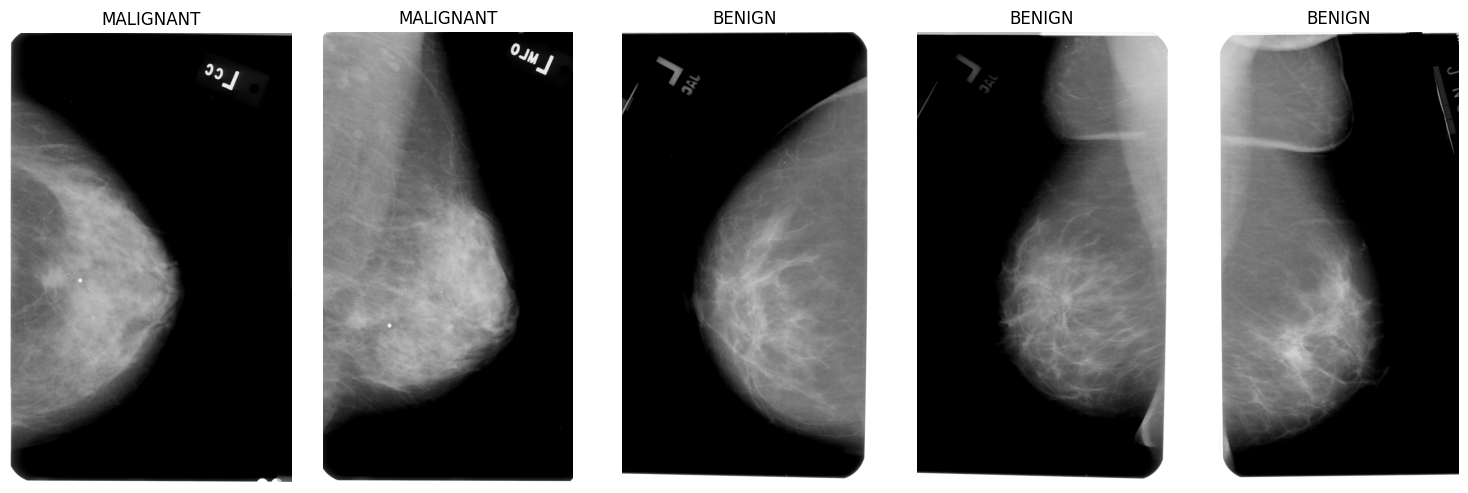

Cropped Mammograms:



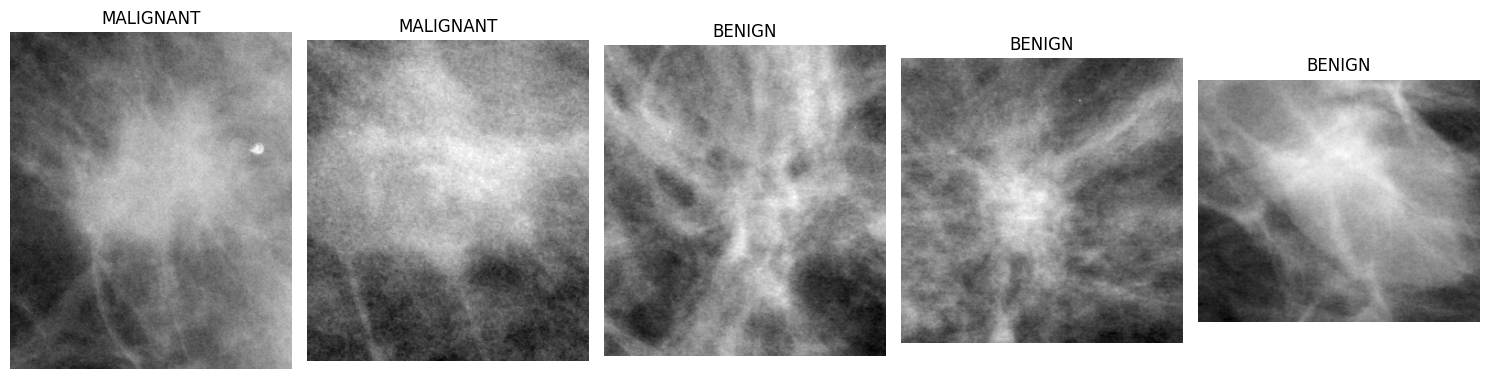

ROI mask:



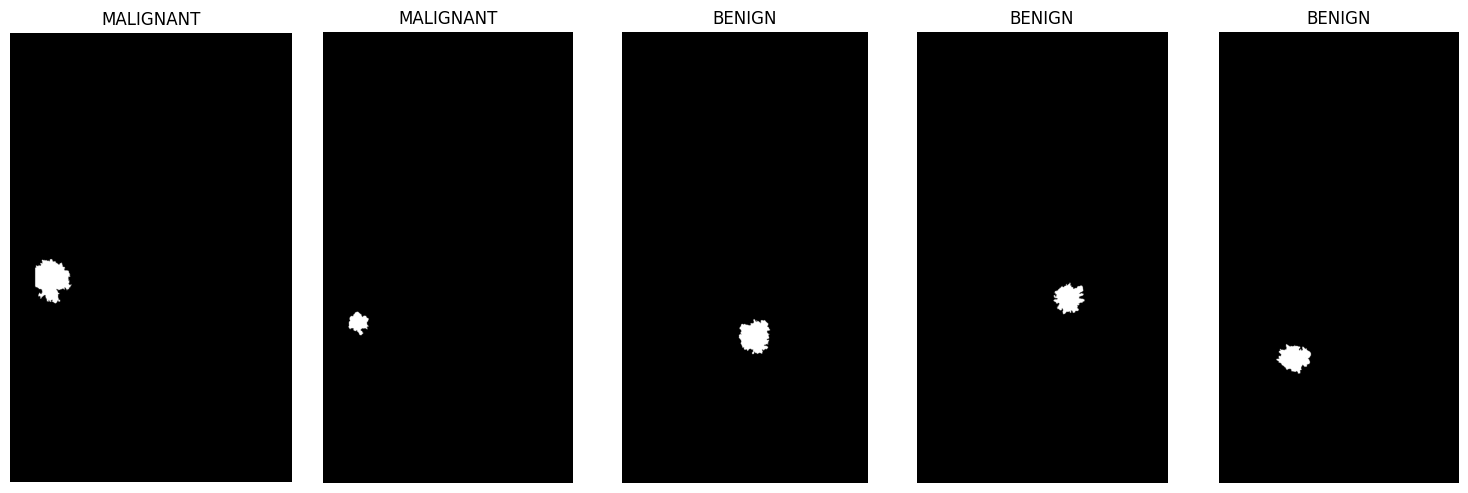

In [23]:
def display_images(column, number):
    # create figure and axes
    number_to_visualize = number
    rows = 1
    cols = number_to_visualize
    fig, axes = plt.subplots(rows, cols, figsize=(15, 5))
    
    # Loop through rows and display images
    for index, row in mass_train.head(number_to_visualize).iterrows():
        image_path = row[column]
        image = mpimg.imread(image_path)
        ax = axes[index]
        ax.imshow(image, cmap='gray')
        ax.set_title(f"{row['pathology']}")
        ax.axis('off')
    plt.tight_layout()
    plt.show()

print('Full Mammograms:\n')
display_images('image_file_path', 5)
print('Cropped Mammograms:\n')
display_images('cropped_image_file_path', 5)
print('ROI mask:\n')
display_images('ROI_mask_file_path', 5)

In [24]:
df_1122= pd.read_csv('/kaggle/input/siim-isic-melanoma-classification/train.csv')
print(df_1122.head(5))

     image_name  patient_id     sex  age_approx anatom_site_general_challenge  \
0  ISIC_2637011  IP_7279968    male        45.0                     head/neck   
1  ISIC_0015719  IP_3075186  female        45.0               upper extremity   
2  ISIC_0052212  IP_2842074  female        50.0               lower extremity   
3  ISIC_0068279  IP_6890425  female        45.0                     head/neck   
4  ISIC_0074268  IP_8723313  female        55.0               upper extremity   

  diagnosis benign_malignant  target  
0   unknown           benign       0  
1   unknown           benign       0  
2     nevus           benign       0  
3   unknown           benign       0  
4   unknown           benign       0  


In [25]:
df_2211 = pd.read_csv('/kaggle/input/siim-isic-melanoma-classification/test.csv')
print(df_2211.head(5))

     image_name  patient_id     sex  age_approx anatom_site_general_challenge
0  ISIC_0052060  IP_3579794    male        70.0                           NaN
1  ISIC_0052349  IP_7782715    male        40.0               lower extremity
2  ISIC_0058510  IP_7960270  female        55.0                         torso
3  ISIC_0073313  IP_6375035  female        50.0                         torso
4  ISIC_0073502  IP_0589375  female        45.0               lower extremity


In [29]:


def process_dcm(file_path):
    ds = pydicom.dcmread(file_path)
    im = ds.pixel_array
    im = im.astype(float)
    # simple normalization, convert to RGB
    im = im / im.max()
    im2 = np.zeros(list(im.shape) + [3])
    for i in range(3):
        im2[:, :, i] = im
    im = (255 * im2).astype(np.uint8)

    return im


def create_clip_feature_mat(file_list, clip_model, preprocess_fxn):
    X = np.zeros((len(file_list), 512)) # 512 is feature dimension
    for i, f in tqdm(enumerate(file_list), total=len(file_list)):
        if '.dcm' in f:
            im = Image.fromarray(process_dcm(f))
        else:
            im = Image.open(f)
            if im.mode != 'RGB':             
                im = im.convert('RGB')    
        im = preprocess_fxn(im).unsqueeze(0).to(device)
        with torch.no_grad():
            image_features = clip_model.encode_image(im)
        X[i] = image_features[0].cpu()

    return X


from scipy.spatial import distance
from sklearn.metrics import (
    roc_auc_score, accuracy_score, f1_score, recall_score, confusion_matrix
)
from statsmodels.stats.proportion import proportion_confint
import pandas as pd
import numpy as np
import os

def fit_words(train_df, test_df, device, word_list, save_dir, save_tag):
    # ——— 1) 加载 CLIP ———
    clip_model, preprocess_fxn = clip.load("ViT-B/32", device=device)

    # ——— 2) 提取 CLIP image 特征 ———
    X_train = create_clip_feature_mat(train_df.file_path.values, clip_model, preprocess_fxn)

    # ——— 3) CLIP feature 上的 LogisticRegression ———
    classifier = LogisticRegression(
        random_state=0, C=1, max_iter=1000, verbose=1, fit_intercept=False
    )
    classifier.fit(X_train, train_df.label.values)

    # ——— 4) 提取 word embeddings & 拟合 word→coef ———
    tokened_words  = clip.tokenize(word_list).to(device)
    with torch.no_grad():
        word_features = clip_model.encode_text(tokened_words)  # [n_words, 512]

    weights_model = LinearRegression(fit_intercept=False)
    weights_model.fit(
        word_features.cpu().T,            # [512, n_words]
        classifier.coef_[0]               # [512, ]
    )

    # ——— 5) 保存并打印 word weights 
    word_df = pd.DataFrame({
        'word':    word_list,
        'weight':  weights_model.coef_
    }).set_index('word').sort_values('weight')

    # 计算每个词的绝对权重占比
    abs_sum = word_df['weight'].abs().sum()
    word_df['prop'] = word_df['weight'].abs() / abs_sum


    word_df.to_csv(os.path.join(save_dir, f'word_weights-{save_tag}.csv'))
    print(f"\n=== [{save_tag}] Descriptor Weights & Proportions ===")
    print(word_df.round(3))

    # ——— 6) 测试集上 CLIP→LR 的性能 ———
    X_test   = create_clip_feature_mat(test_df.file_path.values, clip_model, preprocess_fxn)
    y_true   = test_df.label.values
    y_score  = classifier.predict_proba(X_test)[:, 1]
    y_pred   = classifier.predict(X_test)

    # 6a) 基本指标
    acc   = accuracy_score(y_true, y_pred)
    auc   = roc_auc_score(y_true, y_score)
    f1    = f1_score(y_true, y_pred)
    sens  = recall_score(y_true, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    spec  = tn/(tn+fp)

    # 6b) 置信区间
    n = len(y_true)
    ci_acc_low, ci_acc_hi   = proportion_confint(acc*n, n, method='wilson')
    ci_sens_low, ci_sens_hi = proportion_confint(tp, tp+fn, method='wilson')
    ci_spec_low, ci_spec_hi = proportion_confint(tn, tn+fp, method='wilson')

    print(f"\n=== [{save_tag}] CLIP→LR  Performance ===")
    print(f"Accuracy:    {acc:.3f} (95% CI [{ci_acc_low:.3f},{ci_acc_hi:.3f}])")
    print(f"AUC:         {auc:.3f}")
    print(f"F1:          {f1:.3f}")
    print(f"Sensitivity: {sens:.3f} (95% CI [{ci_sens_low:.3f},{ci_sens_hi:.3f}])")
    print(f"Specificity: {spec:.3f} (95% CI [{ci_spec_low:.3f},{ci_spec_hi:.3f}])")

    # ——— 7) Descriptor→LR Performance ———
    W = word_features.cpu().numpy()                # [n_words,512]
    X_desc_train = X_train.dot(W.T)                # [n_samples, n_words]
    X_desc_test  = X_test.dot(W.T)

    desc_clf = LogisticRegression(random_state=0, C=1, max_iter=1000, fit_intercept=False)
    desc_clf.fit(X_desc_train, train_df.label.values)

    y_score_d = desc_clf.predict_proba(X_desc_test)[:,1]
    y_pred_d  = desc_clf.predict(X_desc_test)

    acc_d   = accuracy_score(y_true, y_pred_d)
    auc_d   = roc_auc_score(y_true, y_score_d)
    f1_d    = f1_score(y_true, y_pred_d)
    sens_d  = recall_score(y_true, y_pred_d)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred_d).ravel()
    spec_d  = tn/(tn+fp)

    print(f"\n=== [{save_tag}] Descriptor→LR Performance ===")
    print(f"Accuracy:    {acc_d:.3f}")
    print(f"AUC:         {auc_d:.3f}")
    print(f"F1:          {f1_d:.3f}")
    print(f"Sensitivity: {sens_d:.3f}")
    print(f"Specificity: {spec_d:.3f}")

    # ——— 8) 余弦相似度 
    pred_coef = weights_model.predict(W.T)
    cos_sim   = 1 - distance.cosine(pred_coef, classifier.coef_[0])
    print(f"\nCosine similarity (word→coef vs CLIP→coef): {cos_sim:.3f}\n")


def get_prototypes(df, words, device, save_dir, n_save=20):
    clip_model, preprocess_fxn = clip.load("ViT-B/32", device=device)
    X = create_clip_feature_mat(df.file_path.values, clip_model, preprocess_fxn)

    tokened_words = clip.tokenize(words).to(device)
    with torch.no_grad():
        word_features = clip_model.encode_text(tokened_words)

    file_dot = np.zeros((len(df), len(words)))
    for i in range(len(df)):
        for j in range(len(words)):
            file_dot[i, j] = np.dot(X[i], word_features[j].cpu())

    file_dot_pred = np.zeros((len(df), len(words)))
    for j in range(len(words)):
        fit_j = [k for k in range(len(words)) if k != j]
        dot_regression = LinearRegression()
        dot_regression.fit(file_dot[:, fit_j], file_dot[:, j])
        file_dot_pred[:, j] = dot_regression.predict(file_dot[:, fit_j])

    dot_df_diff = pd.DataFrame(file_dot - file_dot_pred, columns=words)
    dot_df_diff['label'] = df['label'].values
    dot_df_diff.set_index(df.file_path, inplace=True)

    for w in words:
        print(w)
        for sort_dir in ['top']:
            this_df = dot_df_diff.sort_values(w, ascending=(sort_dir == 'bottom'))
            save_files = this_df.index.values[:n_save]
            these_labels = this_df.label.values[:n_save]
            this_out_dir = save_dir + w + '_' + sort_dir + '/'
            if not os.path.exists(this_out_dir):
                os.mkdir(this_out_dir)

            for i, f in enumerate(save_files):
                if '.dcm' in f:
                    im = process_dcm(f)
                else:
                    im = imageio.imread(f)
                    if im.ndim == 2:                        
                        im = np.stack([im]*3, axis=-1)      
                    elif im.shape[-1] == 4:                   
                        im = im[..., :3]
                # make square and downsample for efficiency 
                min_dim = min(im.shape[:2])
                for dim in [0, 1]:
                    if im.shape[dim] > min_dim:
                        n_start = int((im.shape[dim] - min_dim) / 2)
                        n_stop = n_start + min_dim
                        if dim == 0:
                            im = im[n_start:n_stop, :, :]
                        else:
                            im = im[:, n_start:n_stop, :]
                if min_dim > 500:
                    im = cv2.resize(im, (500, 500))
                f_name = f'rank{i}_label{these_labels[i]}.png'
                imageio.imwrite(os.path.join(this_out_dir, f_name), im)


if __name__ == '__main__':
    dataset_name = 'cbis'
    device = 'cuda:0'

    if dataset_name == 'cbis':
        train_df = mass_train[['cropped_image_file_path', 'pathology']].copy()
        train_df.rename(columns={'cropped_image_file_path': 'file_path'}, inplace=True)
        train_df['label'] = (train_df['pathology'] == 'MALIGNANT').astype(int)
        train_df.drop(columns=['pathology'], inplace=True)

        test_df = mass_test[['cropped_image_file_path', 'pathology']].copy()
        test_df.rename(columns={'cropped_image_file_path': 'file_path'}, inplace=True)
        test_df['label'] = (test_df['pathology'] == 'MALIGNANT').astype(int)
        test_df.drop(columns=['pathology'], inplace=True)

    elif dataset_name == 'melanoma':
        train_df = pd.read_csv('./data/siim_melanoma_train.csv')
        test_df  = pd.read_csv('./data/siim_melanoma_test.csv')

    words = [
        'dark', 'light', 'round', 'pointed', 'large', 'small',
        'smooth', 'coarse', 'transparent', 'opaque',
        'symmetric', 'asymmetric', 'high contrast', 'low contrast'
    ]

    base_out_dir = './results/'
    os.makedirs(base_out_dir, exist_ok=True)

    save_tag = dataset_name
    save_dir = os.path.join(base_out_dir, save_tag)
    os.makedirs(save_dir, exist_ok=True)

    fit_words(train_df, test_df, device, words,
              save_dir=save_dir, save_tag=save_tag)

    prot_save_dir = os.path.join(save_dir, save_tag + '_prototypes')
    os.makedirs(prot_save_dir, exist_ok=True)
    get_prototypes(train_df, words, device, prot_save_dir, n_save=5)

100%|██████████| 1318/1318 [00:17<00:00, 74.04it/s]



=== [cbis] Descriptor Weights & Proportions ===
               weight   prop
word                        
smooth         -0.205  0.133
high contrast  -0.165  0.107
symmetric      -0.134  0.087
small          -0.101  0.065
transparent    -0.091  0.059
round          -0.068  0.044
dark           -0.042  0.027
opaque         -0.000  0.000
pointed         0.033  0.022
large           0.046  0.030
asymmetric      0.091  0.059
coarse          0.111  0.072
light           0.173  0.112
low contrast    0.285  0.184


100%|██████████| 378/378 [00:05<00:00, 75.03it/s]



=== [cbis] CLIP→LR  Performance ===
Accuracy:    0.717 (95% CI [0.670,0.760])
AUC:         0.780
F1:          0.654
Sensitivity: 0.687 (95% CI [0.608,0.756])
Specificity: 0.736 (95% CI [0.676,0.789])

=== [cbis] Descriptor→LR Performance ===
Accuracy:    0.601
AUC:         0.646
F1:          0.527
Sensitivity: 0.571
Specificity: 0.619

Cosine similarity (word→coef vs CLIP→coef): 0.162



100%|██████████| 1318/1318 [00:17<00:00, 75.20it/s]


dark
light


<ipython-input-29-5838ffc96c15>:178: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  im = imageio.imread(f)


round
pointed
large
small
smooth
coarse
transparent
opaque
symmetric
asymmetric
high contrast
low contrast


In [30]:
# CLIP+MLP 微调
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, roc_auc_score
from tqdm import tqdm
from PIL import Image

# —— 1) 准备数据集 —— 
class PatchDataset(Dataset):
    def __init__(self, df, preprocess):
        self.paths = df.file_path.values
        self.labels = df.label.values.astype('float32')
        self.preprocess = preprocess
    def __len__(self):
        return len(self.paths)
    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert('RGB')
        x = self.preprocess(img)
        y = torch.tensor(self.labels[idx], dtype=torch.float32)
        return x, y

# —— 2) 加载 CLIP backbone & preproces
clip_model, preprocess_fxn = clip.load("ViT-B/32", device=device)
clip_model = clip_model.float()  

# Dataset & DataLoader
train_ds = PatchDataset(train_df, preprocess_fxn)
test_ds  = PatchDataset(test_df,  preprocess_fxn)
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True,  num_workers=2)
test_loader  = DataLoader(test_ds,  batch_size=64, shuffle=False, num_workers=2)

# —— 3) 搭建模型 —— 
class FineTuneMLP(nn.Module):
    def __init__(self, backbone, hidden_dim=1024, dropout_p=0.3):
        super().__init__()
        self.vision = backbone.visual.float()   # 确保 vision 也是单精度
        for p in self.vision.parameters():
            p.requires_grad = False

        d = self.vision.output_dim
        self.head = nn.Sequential(
            nn.Linear(d, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_p),
            nn.Linear(hidden_dim, hidden_dim//2),
            nn.ReLU(),
            nn.Dropout(dropout_p),
            nn.Linear(hidden_dim//2, 1)
        ).float() 

    def forward(self, x):
        f = self.vision(x)         
        return self.head(f).squeeze(1)  

model_ft = FineTuneMLP(clip_model).to(device)

# —— 4) 损失、优化器、调度 —— 
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW([
    {'params': model_ft.vision.parameters(), 'lr': 5e-6},
    {'params': model_ft.head.parameters(),   'lr': 2e-4}
], weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)

# —— 5) 训练 —— 
num_epochs = 20
for epoch in range(1, num_epochs+1):
    model_ft.train()
    running_loss = 0.0
    for xb, yb in tqdm(train_loader, desc=f"Epoch {epoch}/{num_epochs}"):
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        logits = model_ft(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * xb.size(0)
    scheduler.step()
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch {epoch}/{num_epochs}, Train Loss: {epoch_loss:.4f}")

# —— 6) 在训练 & 测试集上评估 —— 
def eval_split(loader):
    model_ft.eval()
    ys, ps = [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            logit = model_ft(xb).cpu().numpy()
            prob  = 1 / (1 + np.exp(-logit))
            ys.append(yb.numpy()); ps.append(prob)
    y_true = np.concatenate(ys)
    y_prob = np.concatenate(ps)
    y_pred = (y_prob >= 0.5).astype(int)
    return y_true, y_pred, y_prob

y_tr, p_tr, prob_tr = eval_split(train_loader)
y_te, p_te, prob_te = eval_split(test_loader)

acc_tr = accuracy_score(y_tr, p_tr)
auc_tr = roc_auc_score(y_tr, prob_tr)
acc_te = accuracy_score(y_te, p_te)
auc_te = roc_auc_score(y_te, prob_te)

print("\n=== [CBIS] CLIP→MLP Improved Performance ===")
print(f"[Train set] Accuracy: {acc_tr:.3f}, AUC: {auc_tr:.3f}")
print(f"[Test  set] Accuracy: {acc_te:.3f}, AUC: {auc_te:.3f}")


Epoch 1/20: 100%|██████████| 42/42 [00:06<00:00,  6.87it/s]


Epoch 1/20, Train Loss: 0.6713


Epoch 2/20: 100%|██████████| 42/42 [00:04<00:00,  9.49it/s]


Epoch 2/20, Train Loss: 0.6169


Epoch 3/20: 100%|██████████| 42/42 [00:04<00:00,  9.08it/s]


Epoch 3/20, Train Loss: 0.5909


Epoch 4/20: 100%|██████████| 42/42 [00:04<00:00,  9.27it/s]


Epoch 4/20, Train Loss: 0.5815


Epoch 5/20: 100%|██████████| 42/42 [00:04<00:00,  9.15it/s]


Epoch 5/20, Train Loss: 0.5849


Epoch 6/20: 100%|██████████| 42/42 [00:04<00:00,  9.41it/s]


Epoch 6/20, Train Loss: 0.5646


Epoch 7/20: 100%|██████████| 42/42 [00:04<00:00,  9.30it/s]


Epoch 7/20, Train Loss: 0.5641


Epoch 8/20: 100%|██████████| 42/42 [00:04<00:00,  8.87it/s]


Epoch 8/20, Train Loss: 0.5522


Epoch 9/20: 100%|██████████| 42/42 [00:04<00:00,  9.31it/s]


Epoch 9/20, Train Loss: 0.5353


Epoch 10/20: 100%|██████████| 42/42 [00:04<00:00,  8.91it/s]


Epoch 10/20, Train Loss: 0.5288


Epoch 11/20: 100%|██████████| 42/42 [00:04<00:00,  8.96it/s]


Epoch 11/20, Train Loss: 0.5277


Epoch 12/20: 100%|██████████| 42/42 [00:04<00:00,  9.00it/s]


Epoch 12/20, Train Loss: 0.5265


Epoch 13/20: 100%|██████████| 42/42 [00:04<00:00,  8.89it/s]


Epoch 13/20, Train Loss: 0.5192


Epoch 14/20: 100%|██████████| 42/42 [00:04<00:00,  8.47it/s]


Epoch 14/20, Train Loss: 0.5122


Epoch 15/20: 100%|██████████| 42/42 [00:04<00:00,  8.44it/s]


Epoch 15/20, Train Loss: 0.5063


Epoch 16/20: 100%|██████████| 42/42 [00:04<00:00,  9.03it/s]


Epoch 16/20, Train Loss: 0.4988


Epoch 17/20: 100%|██████████| 42/42 [00:04<00:00,  9.21it/s]


Epoch 17/20, Train Loss: 0.4949


Epoch 18/20: 100%|██████████| 42/42 [00:04<00:00,  8.99it/s]


Epoch 18/20, Train Loss: 0.4945


Epoch 19/20: 100%|██████████| 42/42 [00:04<00:00,  9.11it/s]


Epoch 19/20, Train Loss: 0.4907


Epoch 20/20: 100%|██████████| 42/42 [00:04<00:00,  8.87it/s]

Epoch 20/20, Train Loss: 0.4928



--- [CBIS CLIP→MLP (Train)] ---
Accuracy:    0.772
AUC:         0.851
Precision:   0.783
Sensitivity: 0.730
Specificity: 0.811
F1-score:    0.755

--- [CBIS CLIP→MLP ( Test)] ---
Accuracy:    0.712
AUC:         0.780
Precision:   0.620
Sensitivity: 0.667
Specificity: 0.740
F1-score:    0.643

[MLP head] top-5 weight proportions:
 dim 213 | weight    0.054 | prop  0.39%
 dim 440 | weight    0.054 | prop  0.39%
 dim 227 | weight    0.052 | prop  0.38%
 dim 112 | weight   -0.052 | prop  0.38%
 dim 324 | weight    0.052 | prop  0.38%


100%|██████████| 1318/1318 [00:18<00:00, 70.63it/s]



=== All Word Weights and Proportions ===
         word  weight   prop
 low contrast  0.3450 0.1443
       smooth -0.2545 0.1064
         left -0.2233 0.0934
        light  0.2190 0.0916
high contrast -0.1875 0.0784
        right  0.1605 0.0671
    symmetric -0.1395 0.0583
          MLO -0.1359 0.0568
  transparent -0.1115 0.0466
       coarse  0.1089 0.0455
   asymmetric  0.1082 0.0452
        large  0.1042 0.0436
        small -0.0804 0.0336
           CC  0.0624 0.0261
        round -0.0578 0.0242
      pointed  0.0488 0.0204
         dark -0.0336 0.0141
       opaque -0.0100 0.0042
🚦 Shortcut Word Weights 🚦
  left : -0.2233
 right :  0.1605
    CC :  0.0624
   MLO : -0.1359

🔍 Prototypes for “left” (label shown under each):


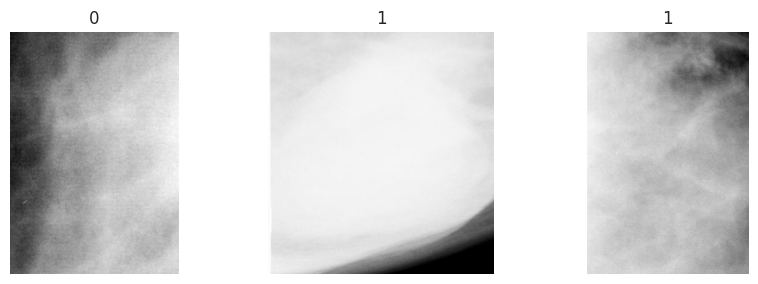

🔍 Prototypes for “right” (label shown under each):


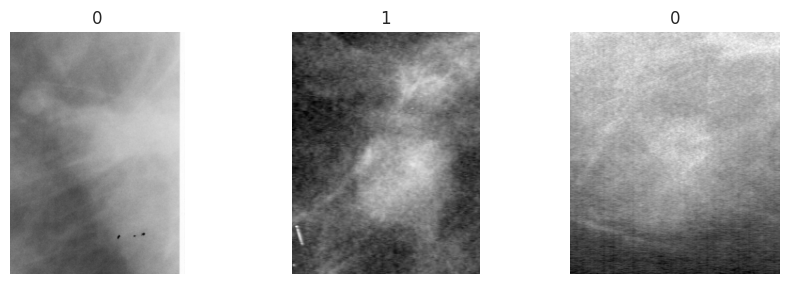

🔍 Prototypes for “CC” (label shown under each):


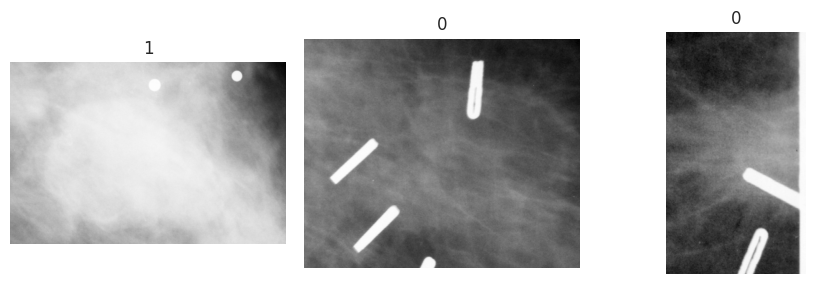

🔍 Prototypes for “MLO” (label shown under each):


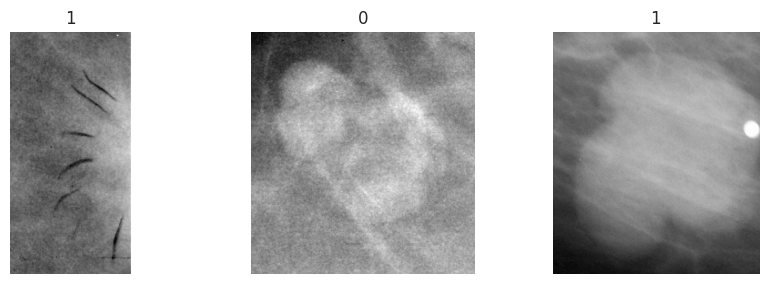

In [31]:
# === Shortcut Analysis Inline ===

import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.spatial import distance
from PIL import Image

# 原来的14个描述词
orig_words = [
    'dark', 'light', 'round', 'pointed',
    'large', 'small', 'smooth', 'coarse',
    'transparent', 'opaque', 'symmetric', 'asymmetric',
    'high contrast', 'low contrast'
]
# \要检测的 shortcut 词
shortcut_words = ['left', 'right', 'CC', 'MLO']
all_words = orig_words + shortcut_words

# 1) 训练 CLIP→LR
clip_model, preprocess_fxn = clip.load("ViT-B/32", device=device)
X_train = create_clip_feature_mat(train_df.file_path.values, clip_model, preprocess_fxn)
clf = LogisticRegression(random_state=0, C=1, max_iter=1000, fit_intercept=False)
clf.fit(X_train, train_df.label.values)

# 2) 计算所有词的 embedding 并拟合线性回归以得到权重
tokened = clip.tokenize(all_words).to(device)
with torch.no_grad():
    word_feats = clip_model.encode_text(tokened).cpu().numpy()   # shape [len(all_words),512]

lm = LinearRegression(fit_intercept=False)
lm.fit(word_feats.T, clf.coef_[0])
weights = dict(zip(all_words, lm.coef_))

# 打印所有词的权重及其占比
abs_w = np.array([abs(weights[w]) for w in all_words])
prop = abs_w / abs_w.sum()
# 构造 DataFrame 排序显示
import pandas as pd
df_w = pd.DataFrame({
    'word': all_words,
    'weight': [weights[w] for w in all_words],
    'prop'  : prop
})
df_w = df_w.sort_values('prop', ascending=False).reset_index(drop=True)
print("\n=== All Word Weights and Proportions ===")
print(df_w.to_string(index=False, float_format="%.4f"))

# 3) 打印 shortcut 词的权重
print("🚦 Shortcut Word Weights 🚦")
for w in shortcut_words:
    print(f"{w:>6s} : {weights[w]: .4f}")
print()

# 4) 计算 residuals = dot - dot_pred，用来找 prototypical examples
#    file_dot[i,j] = X_train[i]·word_feats[j]
file_dot = X_train.dot(word_feats.T)  # shape [N_train, len(all_words)]
file_dot_pred = np.zeros_like(file_dot)
for j in range(len(all_words)):
    others = [k for k in range(len(all_words)) if k != j]
    reg = LinearRegression(fit_intercept=False).fit(file_dot[:, others], file_dot[:, j])
    file_dot_pred[:, j] = reg.predict(file_dot[:, others])
residuals = file_dot - file_dot_pred   # shape [N_train, len(all_words)]

# 5) 对每个 shortcut 词，展示 top-3 的训练图像
TOP_K = 3
for w in shortcut_words:
    j = all_words.index(w)
    top_idxs = np.argsort(residuals[:, j])[::-1][:TOP_K]
    print(f"🔍 Prototypes for “{w}” (label shown under each):")
    fig, axes = plt.subplots(1, TOP_K, figsize=(TOP_K*3, 3))
    for ax, idx in zip(axes, top_idxs):
        path = train_df.file_path.iloc[idx]
        img = Image.open(path).convert('RGB')
        ax.imshow(img)
        ax.set_title(train_df.label.iloc[idx])
        ax.axis('off')
    plt.tight_layout()
    plt.show()


In [34]:
#  Vocabulary Expansion + Full Pipeline 

# 1. 定义扩充后的词表
extended_words = [
    # 原始通用视觉词
    'dark', 'light', 'round', 'pointed', 'large', 'small',
    'smooth', 'coarse', 'transparent', 'opaque',
    'symmetric', 'asymmetric', 'high contrast', 'low contrast',
    # 新增医学相关词
    'spiculated', 'lobulated', 'microlobulated', 'heterogeneous texture',
    'calcified', 'architectural distortion', 'microcalcifications'
]

# 2. 重新运行 fit_words，得到新 word_weights
fit_words(
    train_df, test_df, device,
    word_list=extended_words,
    save_dir=save_dir,
    save_tag='cbis_extvocab'
)


# 3. 重新加载新权重，打印完整列表
import pandas as pd

wd = pd.read_csv(
    os.path.join(save_dir, 'word_weights-cbis_extvocab.csv'),
    index_col=0
)

print("=== Descriptor Weights (extended vocab) ===")
# wd 里第一列即是权重，直接 to_string 打印全部词汇
print(wd.to_string(float_format="%.4f"))

# 4. 在扩充词表上训练 Descriptor→LR & Descriptor→MLP

# 4.1 构造 descriptor 特征 (重新计算或复用)
clip_model, preprocess_fxn = clip.load("ViT-B/32", device=device)
X_train = create_clip_feature_mat(train_df.file_path.values, clip_model, preprocess_fxn)
X_test  = create_clip_feature_mat(test_df.file_path.values,  clip_model, preprocess_fxn)

# 文本特征
tokened = clip.tokenize(extended_words).to(device)
with torch.no_grad():
    word_feats = clip_model.encode_text(tokened).cpu().numpy()  # [W,512]

# 点乘得到 descriptor 特征
Xw_train = X_train.dot(word_feats.T)  # [N_train, W]
Xw_test  = X_test.dot(word_feats.T)   # [N_test,  W]

# 4.2 Descriptor→LR
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score

clf2 = LogisticRegression(
    max_iter=1000,
    random_state=0,
    fit_intercept=False
)
clf2.fit(Xw_train, train_df.label.values)

y2_tr = clf2.predict(Xw_train)
p2_tr = clf2.predict_proba(Xw_train)[:,1]
y2_te = clf2.predict(Xw_test)
p2_te = clf2.predict_proba(Xw_test)[:,1]

print("\n=== Descriptor→LR with extended vocab ===")
print(f"Train Acc {accuracy_score(train_df.label, y2_tr):.3f}, "
      f"AUC {roc_auc_score(train_df.label, p2_tr):.3f}")
print(f" Test Acc {accuracy_score(test_df.label, y2_te):.3f}, "
      f"AUC {roc_auc_score(test_df.label, p2_te):.3f}")

# 4.3 Descriptor→MLP
from sklearn.neural_network import MLPClassifier

mlp2 = MLPClassifier(
    hidden_layer_sizes=(32,),
    activation='relu',
    solver='adam',
    max_iter=300,
    random_state=42
)
mlp2.fit(Xw_train, train_df.label.values)

y3_tr = mlp2.predict(Xw_train)
p3_tr = mlp2.predict_proba(Xw_train)[:,1]
y3_te = mlp2.predict(Xw_test)
p3_te = mlp2.predict_proba(Xw_test)[:,1]

print("\n=== Descriptor→MLP with extended vocab ===")
print(f"Train Acc {accuracy_score(train_df.label, y3_tr):.3f}, "
      f"AUC {roc_auc_score(train_df.label, p3_tr):.3f}")
print(f" Test Acc {accuracy_score(test_df.label, y3_te):.3f}, "
      f"AUC {roc_auc_score(test_df.label, p3_te):.3f}")


100%|██████████| 1318/1318 [00:17<00:00, 73.79it/s]



=== [cbis_extvocab] Descriptor Weights & Proportions ===
                          weight   prop
word                                   
smooth                    -0.204  0.104
high contrast             -0.157  0.080
symmetric                 -0.132  0.067
small                     -0.100  0.051
microlobulated            -0.096  0.049
calcified                 -0.075  0.039
transparent               -0.073  0.038
heterogeneous texture     -0.062  0.032
round                     -0.052  0.027
dark                      -0.046  0.024
opaque                    -0.004  0.002
spiculated                 0.001  0.001
lobulated                  0.034  0.018
architectural distortion   0.036  0.018
pointed                    0.037  0.019
large                      0.038  0.020
asymmetric                 0.100  0.051
microcalcifications        0.104  0.053
coarse                     0.133  0.068
light                      0.177  0.091
low contrast               0.288  0.148


100%|██████████| 378/378 [00:05<00:00, 71.90it/s]



=== [cbis_extvocab] CLIP→LR  Performance ===
Accuracy:    0.717 (95% CI [0.670,0.760])
AUC:         0.780
F1:          0.654
Sensitivity: 0.687 (95% CI [0.608,0.756])
Specificity: 0.736 (95% CI [0.676,0.789])

=== [cbis_extvocab] Descriptor→LR Performance ===
Accuracy:    0.593
AUC:         0.657
F1:          0.519
Sensitivity: 0.565
Specificity: 0.610

Cosine similarity (word→coef vs CLIP→coef): 0.169

=== Descriptor Weights (extended vocab) ===
                          weight   prop
word                                   
smooth                   -0.2038 0.1045
high contrast            -0.1568 0.0804
symmetric                -0.1316 0.0675
small                    -0.0998 0.0512
microlobulated           -0.0965 0.0495
calcified                -0.0752 0.0385
transparent              -0.0733 0.0376
heterogeneous texture    -0.0620 0.0318
round                    -0.0521 0.0267
dark                     -0.0462 0.0237
opaque                   -0.0036 0.0019
spiculated                0.

100%|██████████| 378/378 [00:04<00:00, 79.47it/s]



=== Descriptor→LR with extended vocab ===
Train Acc 0.666, AUC 0.721
 Test Acc 0.593, AUC 0.657

=== Descriptor→MLP with extended vocab ===
Train Acc 0.522, AUC 0.554
 Test Acc 0.452, AUC 0.451


In [27]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# import pandas as pd
# import numpy as np
# import os

# def make_word_weights_plot(word_df, base_save_path):
#     x = word_df.index.values
#     y = word_df.weights.values
#     x = np.flipud(x)
#     y = np.flipud(y)

#     cmap = plt.get_cmap('RdBu_r')
#     eps = 1e-8
#     normalized_data = (y - np.min(y)) / (np.max(y) - np.min(y) + eps)
#     colors = cmap(normalized_data)

#     sns.set_theme()
#     sns.set_style("ticks")

#     fig, ax = plt.subplots(figsize=(10, 6))
#     bars = ax.bar(range(len(x)), y, color=colors, edgecolor="black")

#     ax.set_xticks(range(len(x)))
#     ax.set_xticklabels(x, rotation=60, ha="right", fontweight="bold")

#     yticks = ax.get_yticks()
#     ax.set_yticks(yticks)
#     ax.set_yticklabels(np.round(yticks, 2), fontweight="bold")

#     ax.set_ylabel("Malignancy Weight", fontweight="bold", size=14)

#     sns.despine(top=True, right=True)
#     plt.tight_layout()

#     for ext in ['png', 'pdf']:
#         plt.savefig(f'{base_save_path}.{ext}', dpi=300, bbox_inches='tight', pad_inches=0.05)
#     plt.close()

# if __name__ == '__main__':
#     save_tag = 'cbis'
#     save_dir = f'./results/{save_tag}/'
#     word_df = pd.read_csv(save_dir + f'word_weights-{save_tag}.csv', index_col=0)
#     make_word_weights_plot(word_df, os.path.join(save_dir, f'{save_tag}_weights_plot'))


In [28]:
# import os

# save_tag = 'cbis'
# save_dir = f'./results/{save_tag}/'
# print("PNG exists:", os.path.exists(os.path.join(save_dir, f'{save_tag}_weights_plot.png')))
# print("PDF exists:", os.path.exists(os.path.join(save_dir, f'{save_tag}_weights_plot.pdf')))


PNG exists: True
PDF exists: True
